## Here, we used new training data that has the newly determined E_0, mstar, and alpha and fixed deltaI to try and predict the deltaR better.


In [1]:
#Load packages
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm

from sklearn import datasets
from sklearn import linear_model
from sklearn.model_selection import train_test_split

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import *

from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler  



## This function will plot the true vs. predicted with various line fits
def plotSummary(true, predicted, name):
    #from pylab import *
    #import numpy as np
    #import matplotlib.pyplot as plt
    
    figure()
    plt.scatter(true,predicted, alpha = 0.2)
    
    plt.title(name)
    plt.xlabel('True')
    plt.ylabel('Predicted')

    xmin, xmax = plt.xlim()
    plt.plot([xmin,xmax], [xmin,xmax], c='r', linewidth = 2)  #line with slope of one

    fit_temp = np.polyfit(true, predicted,1)
    xp = np.linspace(xmin, xmax, 100)
    p = np.poly1d(fit_temp)
    plt.plot(xp, p(xp), '-', color = 'black')
    
    print(' ')
    print('RMSE on test data:', np.sqrt(mean_squared_error(true, predicted)), 'for ', name)
    print('R^2 Score on test data:', r2_score(true, predicted), 'for', name)

    
    return

def myResiduals(testY, predictY):
    ## residuals 1
    i = 0 # resetting i
    iterations = len(testY) # gets number of dots/points
    residual_sum = 0 # initializes sum of residuals
    for i in range (0,iterations): # for every dot/point
       ys = testY # get ys of testing data
       ys = ys.values # take out indexing, data types, names
       y = ys[i]
       predict_ys = predictY.values # get ys of all dots/points
       predict_y = predict_ys[i] # get the y value of the dot/point at specfic x value i
       diff = y - predict_y # find the difference in height
       diff = abs(diff) # take the absolute value
       residual_sum = diff + residual_sum # add specific residual sum at i to sum of residuals
    residual_average = residual_sum/iterations # find the average of the residuals
    print('The average residual for predict:', round(residual_average,4)) # display average of residuals

    minY = min(ys) # find the minimum y value for testing data
    maxY = max(ys) # find the max y value for testing data
    minpredict = min(predictY) # find the min y value for the prediction data
    maxpredict = max(predictY) # find the max y value for the prediction data
    #print('minY', minY, 'maxY', maxY)
    #print('minpredict', minpredict, 'maxpredict', maxpredict)
    rangeY = minY + maxY # find the range of the testing data
    rangepredict = minpredict - maxpredict # find the range of the predictions
    #print('rangeY', rangeY)
    #print('rangepredict', rangepredict)
    residual_percent_rangepredict = (residual_average/abs(rangepredict))*100 # calculate what percent the residual is of the range
    print('Residual is this percent of predict range', round(residual_percent_rangepredict,3), '%')
    
    return


    

## Made new training data with E_0 and mstar fixed. 

In [2]:
#Load the training data

subset = 5 #every 10 mV
start = 50 # for starting at -300mV

peak_names = ['peak1', 'peak2', 'peak3', 'peak4']
locs_names = ['loc1', 'loc2', 'loc3', 'loc4']
width_names = ['width1', 'width2', 'width3','width4']
prom_names = ['prom1', 'prom2', 'prom3', 'prom4']

energy = (pd.read_csv('Training_Data/Hexagon/HexagonBias_v4.csv', header=None)*1000).round().astype(int)
energy_names = ['E_%i_mV' % item for item in list(energy.T[0])]
energy_names2 = energy_names[start::subset]
energy_names3 = energy_names[start::1]

col_names2 = ['deltaI', 'deltaR', 'E_0', 'mstar', 'alpha']+ peak_names + locs_names + width_names + prom_names
col_names2a = ['deltaI', 'deltaR', 'E_0', 'mstar', 'alpha']+ peak_names[1:] + locs_names + width_names + prom_names[1:]

col_names1 = ['deltaI', 'deltaR', 'E_0', 'mstar', 'alpha'] + energy_names

<<<<<<< local
#col_names_both = col_names2 + energy_names2
col_names_both = col_names2a + energy_names2
col_names_a = ['deltaI', 'deltaR', 'E_0', 'mstar', 'alpha'] + energy_names3
=======
col_names3 = col_names2 + energy_names2

>>>>>>> remote

#Randomly distributed delta R values
data1 = pd.read_csv('Training_Data/Hexagon/HexagonTrainingData070518_v13_E0MaDifixed_specPoints.csv', header = None, names = col_names1)
data2 = pd.read_csv('Training_Data/Hexagon/HexagonTrainingData070518_v13_E0MaDifixed_peakinfo.csv', header = None, names = col_names2)
save_random = True
save_uniform = False

#Evenly distributed delta R values
#data1 = pd.read_csv('Training_Data/Hexagon/HexagonTrainingData070518_v13a_E0MaDifixed_specPoints.csv', header = None, names = col_names1)
#data2 = pd.read_csv('Training_Data/Hexagon/HexagonTrainingData070518_v13a_E0MaDifixed_peakinfo.csv', header = None, names = col_names2)
#save_uniform = True
#save_random = False
<<<<<<< local
=======

>>>>>>> remote
data = data2.join(data1.drop(['deltaI', 'deltaR', 'E_0', 'mstar', 'alpha'], axis = 1), how = 'left')
data = data[col_names3]

<<<<<<< local
data1a = data1[col_names_a]
data2a = data2[col_names2a]


X1 = data1a.drop(['deltaI', 'deltaR', 'E_0', 'mstar', 'alpha'], axis = 1)
Y1 = data1a[['deltaR']]

X2 = data2a.drop(['deltaI', 'deltaR', 'E_0', 'mstar', 'alpha'], axis = 1)
Y2 = data2a[['deltaR']]
=======
# Since E_0 is fixed don't include that

X3 = data1.drop(['deltaI', 'deltaR', 'E_0', 'mstar', 'alpha'], axis = 1)
Y3 = data1[['deltaR']]

X4 = data2.drop(['deltaI', 'deltaR', 'E_0', 'mstar', 'alpha'], axis = 1)
Y4 = data2[['deltaR']]
>>>>>>> remote

X = data.drop(['deltaI', 'deltaR', 'E_0', 'mstar', 'alpha'], axis = 1)
Y = data[['deltaR']]

ts1 = 0.3
rs1 = 42

X3_train, X3_test, Y3_train, Y3_test = train_test_split(X3, Y3, test_size = ts1, random_state = rs1)
X4_train, X4_test, Y4_train, Y4_test = train_test_split(X4, Y4, test_size = ts1, random_state = rs1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = ts1, random_state = rs1)


data1.head()

,deltaI,deltaR,E_0,mstar,alpha,E_-400_mV,E_-398_mV,E_-396_mV,E_-394_mV,E_-392_mV,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,0.242,-1.5708,0.4473,0.3771,-12.597,0.047414,0.048460,0.050255,0.052693,0.056124,...,0.78905,0.86855,0.96179,1.0742,1.2038,1.3566,1.5279,1.7158,1.9096,2.0913
1,0.242,-1.5707,0.4473,0.3771,-12.597,0.047410,0.048456,0.050251,0.052689,0.056120,...,0.78913,0.86865,0.96192,1.0744,1.2041,1.3569,1.5283,1.7162,1.9101,2.0918
2,0.242,-1.5705,0.4473,0.3771,-12.597,0.047406,0.048452,0.050247,0.052685,0.056117,...,0.78921,0.86876,0.96206,1.0746,1.2043,1.3572,1.5286,1.7166,1.9105,2.0923
3,0.242,-1.5704,0.4473,0.3771,-12.597,0.047402,0.048448,0.050244,0.052682,0.056113,...,0.78928,0.86886,0.96220,1.0748,1.2045,1.3575,1.5290,1.7170,1.9110,2.0927
4,0.242,-1.5703,0.4473,0.3771,-12.597,0.047398,0.048444,0.050240,0.052678,0.056109,...,0.78936,0.86897,0.96234,1.0749,1.2048,1.3578,1.5294,1.7175,1.9115,2.0932


### E0, mstar, alpha and deltaI Fixed Models

 
RMSE on test data: 1.8002008715677934e-05 for  Delta R
R^2 Score on test data: 0.9999999983956697 for Delta R
 
RMSE on test data: 1.8002008715677934e-05 for  Delta R Zoomed In
R^2 Score on test data: 0.9999999983956697 for Delta R Zoomed In
 
RMSE on test data: 0.013784776757474288 for  Delta R
R^2 Score on test data: 0.9990592996193809 for Delta R


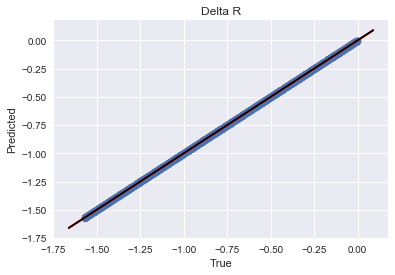

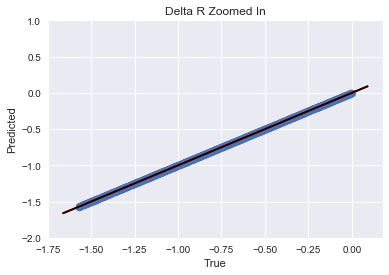

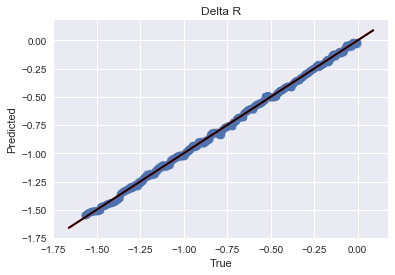

In [3]:
#Initialize and fit OLS model for deltaI 
E0MaDi_model_OLS_R_sp = sm.OLS(Y3_train['deltaR'], X3_train)

E0MaDi_results_OLS_R_sp = E0MaDi_model_OLS_R_sp.fit()

#Make predictions on testing data
E0MaDi_predictions_OLS_R_sp = E0MaDi_results_OLS_R_sp.predict(X3_test)

E0MaDi_scores_OLS = [r2_score(Y3_test['deltaR'], E0MaDi_predictions_OLS_R_sp)]

#If we plot the predictions against the test data, a perfect model should be linear

#ylim([-1,5])
plotSummary(Y3_test['deltaR'], E0MaDi_predictions_OLS_R_sp, 'Delta R')
plotSummary(Y3_test['deltaR'], E0MaDi_predictions_OLS_R_sp, 'Delta R Zoomed In')
ylim([-2,1])

#Initialize and fit OLS model for deltaI 
E0MaDi_model_OLS_R_pi = sm.OLS(Y4_train['deltaR'], X4_train)

E0MaDi_results_OLS_R_pi = E0MaDi_model_OLS_R_pi.fit()

#Make predictions on testing data
E0MaDi_predictions_OLS_R_pi = E0MaDi_results_OLS_R_pi.predict(X4_test)

E0MaDi_scores_OLS_pi = [r2_score(Y4_test['deltaR'], E0MaDi_predictions_OLS_R_pi)]

#If we plot the predictions against the test data, a perfect model should be linear

#ylim([-1,5])
plotSummary(Y4_test['deltaR'], E0MaDi_predictions_OLS_R_pi, 'Delta R')



 
RMSE on test data: 0.0003228929728282831 for  deltaR Depth 60
R^2 Score on test data: 0.9999994838581996 for deltaR Depth 60
 
RMSE on test data: 0.00031578413320042703 for  deltaR Depth 60
R^2 Score on test data: 0.9999995063348666 for deltaR Depth 60


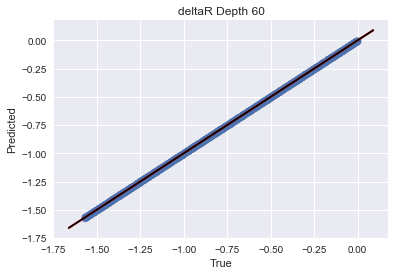

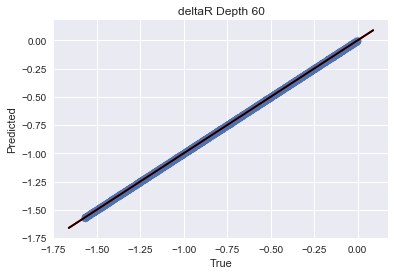

In [4]:
#Initialize the model
rs = 42
E0MaDi_regr_DT_sp = DecisionTreeRegressor(max_depth=60, min_samples_leaf = 2, random_state = rs)

#Fit the model
E0MaDi_regr_DT_sp = E0MaDi_regr_DT_sp.fit(X3_train, Y3_train)


#Use model to predict
E0MaDi_predictions_DT_sp = E0MaDi_regr_DT_sp.predict(X3_test)

E0MaDi_scores_DT = [r2_score(Y3_test['deltaR'], E0MaDi_predictions_DT_sp) ]

#Plot results
#myResiduals(Y_test['deltaI'], y_3[:,0])
plotSummary(Y3_test['deltaR'], E0MaDi_predictions_DT_sp, 'deltaR Depth 60')
#myResiduals(Y_test['deltaR'], y_3[:,1])


#Initialize the model
rs = 42
E0MaDi_regr_DT_pi = DecisionTreeRegressor(max_depth=60, min_samples_leaf = 2, random_state = rs)

#Fit the model
E0MaDi_regr_DT_pi.fit(X4_train, Y4_train)


#print(data1[data1['Regr - DT']>0.001])

#Use model to predict
E0MaDi_predictions_DT_pi = E0MaDi_regr_DT_pi.predict(X4_test)

E0MaDi_scores_DT_pi = [r2_score(Y4_test['deltaR'], E0MaDi_predictions_DT_pi)]

#Plot results
#myResiduals(Y_test['deltaI'], y_3[:,0])
plotSummary(Y4_test['deltaR'], E0MaDi_predictions_DT_pi, 'deltaR Depth 60')
#myResiduals(Y_test['deltaR'], y_3[:,1])




Score - Random Forest: 0.9999997946582749 for delta I/R 10
 
RMSE on test data: 0.00020366325491807878 for  deltaR 10
R^2 Score on test data: 0.999999794658275 for deltaR 10
 
RMSE on test data: 0.00021596833308532248 for  deltaR 10
R^2 Score on test data: 0.9999997690957121 for deltaR 10


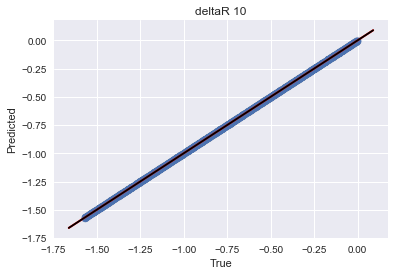

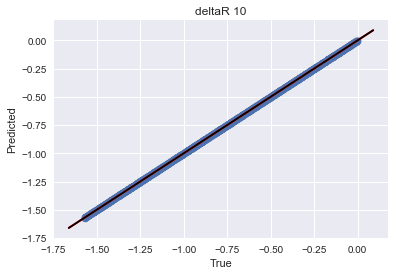

In [5]:
rs = 42
E0MaDi_regr_RF_sp = RandomForestRegressor(max_depth = 40, n_estimators = 30, random_state=rs)

E0MaDi_model_RF_sp = E0MaDi_regr_RF_sp.fit(X3_train, Y3_train['deltaR'])

E0MaDi_predictions_RF_sp = E0MaDi_model_RF_sp.predict(X3_test)

E0MaDi_scores_RF = [r2_score(Y3_test['deltaR'], E0MaDi_predictions_RF_sp)]

print('')
print('Score - Random Forest:' , E0MaDi_model_RF_sp.score(X3_test, Y3_test), 'for delta I/R 10')

plotSummary(Y3_test['deltaR'], E0MaDi_predictions_RF_sp, 'deltaR 10')

rs = 42
E0MaDi_regr_RF_pi = RandomForestRegressor(max_depth = 40, n_estimators = 30, random_state=rs)

E0MaDi_model_RF_pi = E0MaDi_regr_RF_pi.fit(X4_train, Y4_train['deltaR'])

E0MaDi_predictions_RF_pi = E0MaDi_model_RF_pi.predict(X4_test)

E0MaDi_scores_RF_pi = [r2_score(Y4_test['deltaR'], E0MaDi_predictions_RF_pi)]

plotSummary(Y4_test['deltaR'], E0MaDi_predictions_RF_pi, 'deltaR 10')


 
RMSE on test data: 0.0001994691790455367 for  deltaI 10
R^2 Score on test data: 0.9999998030284757 for deltaI 10
 
RMSE on test data: 0.00021596833308532248 for  deltaI 10
R^2 Score on test data: 0.9999997690957121 for deltaI 10


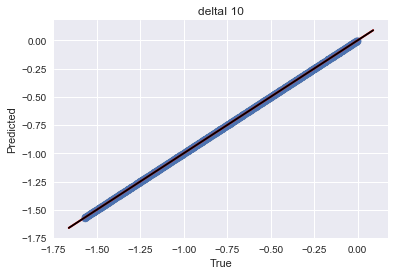

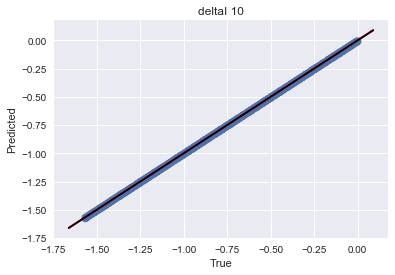

In [6]:
#Trying Independent Random Forest

rs = 42
md = 40
n = 40

E0MaDi_regr_RF2_dr_sp = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)


E0MaDi_model_RF2_dr_sp = E0MaDi_regr_RF2_dr_sp.fit(X3_train, Y3_train['deltaR'])

E0MaDi_predictions_RF2_dr_sp = E0MaDi_model_RF2_dr_sp.predict(X3_test)

E0MaDi_scores_RF2 = [r2_score(Y3_test['deltaR'], E0MaDi_predictions_RF2_dr_sp)]

#importance_RF_10 = pd.Series(model_RF2.feature_importances_, index = X_train.columns)

plotSummary(Y3_test['deltaR'], E0MaDi_predictions_RF2_dr_sp, 'deltaI 10')

#Trying Independent Random Forest

rs = 42
md = 30
n = 30

E0MaDi_regr_RF2_dr_pi = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)

E0MaDi_model_RF2_dr_pi = E0MaDi_regr_RF2_dr_pi.fit(X4_train, Y4_train['deltaR'])

E0MaDi_predictions_RF2_dr_pi = E0MaDi_model_RF2_dr_pi.predict(X4_test)

E0MaDi_scores_RF2_pi = [r2_score(Y4_test['deltaR'], E0MaDi_predictions_RF2_dr_pi)]

plotSummary(Y4_test['deltaR'], E0MaDi_predictions_RF2_dr_pi, 'deltaI 10')




 
RMSE on test data: 0.00021288251227824355 for  AdaBoost Delta R
R^2 Score on test data: 0.9999997756470321 for AdaBoost Delta R
 
RMSE on test data: 0.00022064852093788486 for  AdaBoost Delta R
R^2 Score on test data: 0.9999997589795535 for AdaBoost Delta R


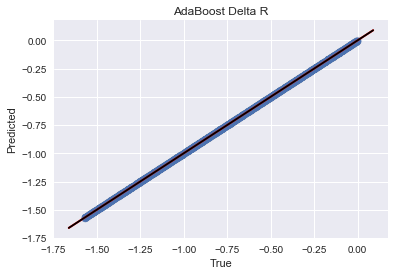

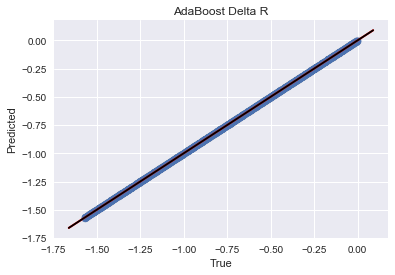

In [7]:
#Using AdaBoost Regression

from sklearn.ensemble import AdaBoostRegressor

rng = 42
md = 30
nest2 = 15

E0MaDi_regr_AB_dr_sp = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)

E0MaDi_model_AB_dr_sp = E0MaDi_regr_AB_dr_sp.fit(X3_train, Y3_train['deltaR'])

E0MaDi_predictions_AB_dr_sp = E0MaDi_model_AB_dr_sp.predict(X3_test)

E0MaDi_scores_AB = [r2_score(Y3_test['deltaR'], E0MaDi_predictions_AB_dr_sp)]

plotSummary(Y3_test['deltaR'], E0MaDi_predictions_AB_dr_sp, 'AdaBoost Delta R')

#Using AdaBoost Regression

from sklearn.ensemble import AdaBoostRegressor

rng = 42
md = 30
nest2 = 15

E0MaDi_regr_AB_dr_pi = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)

E0MaDi_model_AB_dr_pi = E0MaDi_regr_AB_dr_pi.fit(X4_train, Y4_train['deltaR'])

E0MaDi_predictions_AB_dr_pi = E0MaDi_model_AB_dr_pi.predict(X4_test)

E0MaDi_scores_AB_pi = [r2_score(Y4_test['deltaR'], E0MaDi_predictions_AB_dr_pi)]

plotSummary(Y4_test['deltaR'], E0MaDi_predictions_AB_dr_pi, 'AdaBoost Delta R')



 
RMSE on test data: 0.019053301037070147 for  GradientBoost Delta R
R^2 Score on test data: 0.9982028169913786 for GradientBoost Delta R
 
RMSE on test data: 0.01905646347482494 for  GradientBoost Delta R
R^2 Score on test data: 0.998202220354496 for GradientBoost Delta R


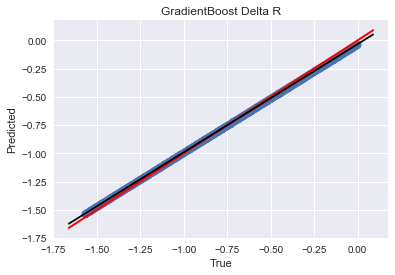

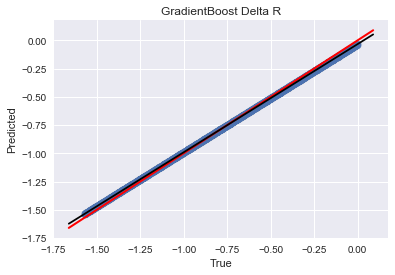

In [8]:
# Using Gradient Boosting Regression

from sklearn.ensemble import GradientBoostingRegressor

rng = 42

md = 50
nest2 = 30


E0MaDi_regr_GB_dr_sp = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)

E0MaDi_model_GB_dr_sp = E0MaDi_regr_GB_dr_sp.fit(X3_train, Y3_train['deltaR'])


E0MaDi_predictions_GB_dr_sp = E0MaDi_model_GB_dr_sp.predict(X3_test)

E0MaDi_scores_GB = [r2_score(Y3_test['deltaR'], E0MaDi_predictions_GB_dr_sp)]

plotSummary(Y3_test['deltaR'], E0MaDi_predictions_GB_dr_sp, 'GradientBoost Delta R')


# Using Gradient Boosting Regression

from sklearn.ensemble import GradientBoostingRegressor

rng = 42

md = 50
nest2 = 30

E0MaDi_regr_GB_dr_pi = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)

E0MaDi_model_GB_dr_pi = E0MaDi_regr_GB_dr_pi.fit(X4_train, Y4_train['deltaR'])

E0MaDi_predictions_GB_dr_pi = E0MaDi_model_GB_dr_pi.predict(X4_test)

E0MaDi_scores_GB_pi = [r2_score(Y4_test['deltaR'], E0MaDi_predictions_GB_dr_pi)]

plotSummary(Y4_test['deltaR'], E0MaDi_predictions_GB_dr_pi, 'GradientBoost Delta R')



 
RMSE on test data: 1.8002008715677934e-05 for  Delta R
R^2 Score on test data: 0.9999999983956697 for Delta R
 
RMSE on test data: 1.8002008715677934e-05 for  Delta R Zoomed In
R^2 Score on test data: 0.9999999983956697 for Delta R Zoomed In
 
RMSE on test data: 0.013784776757474288 for  Delta R
R^2 Score on test data: 0.9990592996193809 for Delta R


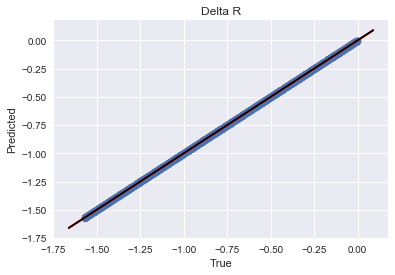

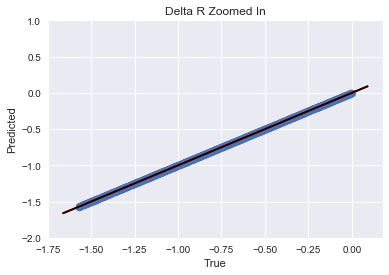

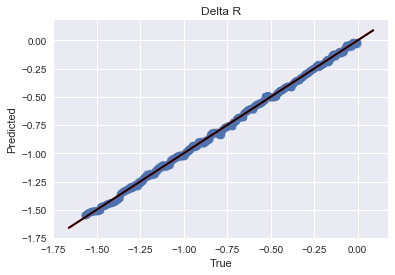

In [3]:
#Initialize and fit OLS model for deltaI 
E0MaDi_model_OLS_R_sp = sm.OLS(Y1_train['deltaR'], X1_train)

E0MaDi_results_OLS_R_sp = E0MaDi_model_OLS_R_sp.fit()

#Make predictions on testing data
E0MaDi_predictions_OLS_R_sp = E0MaDi_results_OLS_R_sp.predict(X1_test)

E0MaDi_scores_OLS = [r2_score(Y1_test['deltaR'], E0MaDi_predictions_OLS_R_sp)]

plotSummary(Y1_test['deltaR'], E0MaDi_predictions_OLS_R_sp, 'Delta R')


In [ ]:
#Initialize and fit OLS model for deltaI 
E0MaDi_model_OLS_R_pi = sm.OLS(Y2_train['deltaR'], X2_train)

E0MaDi_results_OLS_R_pi = E0MaDi_model_OLS_R_pi.fit()

#Make predictions on testing data
E0MaDi_predictions_OLS_R_pi = E0MaDi_results_OLS_R_pi.predict(X2_test)

E0MaDi_scores_OLS_pi = [r2_score(Y2_test['deltaR'], E0MaDi_predictions_OLS_R_pi)]

#If we plot the predictions against the test data, a perfect model should be linear

#ylim([-1,5])
plotSummary(Y2_test['deltaR'], E0MaDi_predictions_OLS_R_pi, 'Delta R')



In [ ]:
#Initialize and fit OLS model for deltaI 
E0MaDi_model_OLS_R_both = sm.OLS(Y_train['deltaR'], X_train)

E0MaDi_results_OLS_R_both = E0MaDi_model_OLS_R_both.fit()

#Make predictions on testing data
E0MaDi_predictions_OLS_R_both = E0MaDi_results_OLS_R_both.predict(X_test)

E0MaDi_scores_OLS_both = [r2_score(Y_test['deltaR'], E0MaDi_predictions_OLS_R_both)]

#If we plot the predictions against the test data, a perfect model should be linear

#ylim([-1,5])
plotSummary(Y_test['deltaR'], E0MaDi_predictions_OLS_R_both, 'Delta R')



 
RMSE on test data: 0.0003228929728282831 for  deltaR Depth 60
R^2 Score on test data: 0.9999994838581996 for deltaR Depth 60
 
RMSE on test data: 0.00031578413320042703 for  deltaR Depth 60
R^2 Score on test data: 0.9999995063348666 for deltaR Depth 60


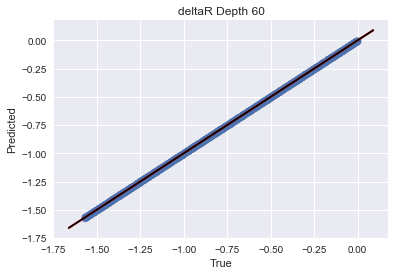

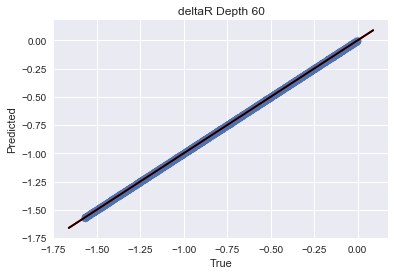

In [4]:
#Initialize the model
rs = 42
E0MaDi_regr_DT_sp = DecisionTreeRegressor(max_depth=60, min_samples_leaf = 2, random_state = rs)

#Fit the model
E0MaDi_regr_DT_sp = E0MaDi_regr_DT_sp.fit(X1_train, Y1_train)


#Use model to predict
E0MaDi_predictions_DT_sp = E0MaDi_regr_DT_sp.predict(X1_test)

E0MaDi_scores_DT = [r2_score(Y1_test['deltaR'], E0MaDi_predictions_DT_sp) ]

#Plot results
#myResiduals(Y_test['deltaI'], y_3[:,0])
plotSummary(Y1_test['deltaR'], E0MaDi_predictions_DT_sp, 'deltaR Depth 60')
#myResiduals(Y_test['deltaR'], y_3[:,1])


In [ ]:
#Initialize the model
rs = 42
E0MaDi_regr_DT_pi = DecisionTreeRegressor(max_depth=60, min_samples_leaf = 2, random_state = rs)

#Fit the model
E0MaDi_regr_DT_pi.fit(X2_train, Y2_train)


#print(data1[data1['Regr - DT']>0.001])

#Use model to predict
E0MaDi_predictions_DT_pi = E0MaDi_regr_DT_pi.predict(X2_test)

E0MaDi_scores_DT_pi = [r2_score(Y2_test['deltaR'], E0MaDi_predictions_DT_pi)]

#Plot results
#myResiduals(Y_test['deltaI'], y_3[:,0])
plotSummary(Y2_test['deltaR'], E0MaDi_predictions_DT_pi, 'deltaR Depth 60')
#myResiduals(Y_test['deltaR'], y_3[:,1])

In [ ]:
#Initialize the model
rs = 42
E0MaDi_regr_DT_both = DecisionTreeRegressor(max_depth=60, min_samples_leaf = 2, random_state = rs)

#Fit the model
E0MaDi_regr_DT_both.fit(X_train, Y_train)


#print(data1[data1['Regr - DT']>0.001])

#Use model to predict
E0MaDi_predictions_DT_both = E0MaDi_regr_DT_both.predict(X_test)

E0MaDi_scores_DT_both = [r2_score(Y_test['deltaR'], E0MaDi_predictions_DT_both)]

#Plot results
#myResiduals(Y_test['deltaI'], y_3[:,0])
plotSummary(Y_test['deltaR'], E0MaDi_predictions_DT_both, 'deltaR Depth 60')
#myResiduals(Y_test['deltaR'], y_3[:,1])


Score - Random Forest: 0.9999997946582749 for delta I/R 10
 
RMSE on test data: 0.00020366325491807878 for  deltaR 10
R^2 Score on test data: 0.999999794658275 for deltaR 10
 
RMSE on test data: 0.00021596833308532248 for  deltaR 10
R^2 Score on test data: 0.9999997690957121 for deltaR 10


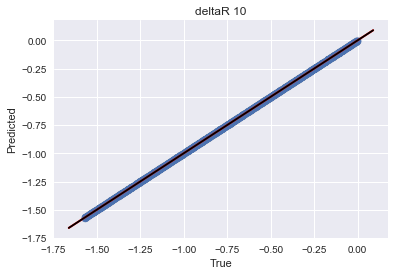

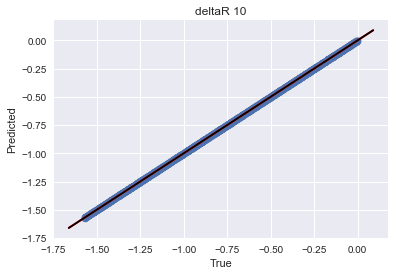

In [5]:
rs = 42
E0MaDi_regr_RF_sp = RandomForestRegressor(max_depth = 40, n_estimators = 30, random_state=rs)

E0MaDi_model_RF_sp = E0MaDi_regr_RF_sp.fit(X1_train, Y1_train['deltaR'])

E0MaDi_predictions_RF_sp = E0MaDi_model_RF_sp.predict(X1_test)

E0MaDi_scores_RF = [r2_score(Y1_test['deltaR'], E0MaDi_predictions_RF_sp)]

plotSummary(Y1_test['deltaR'], E0MaDi_predictions_RF_sp, 'deltaR 10')



In [ ]:
rs = 42
E0MaDi_regr_RF_pi = RandomForestRegressor(max_depth = 40, n_estimators = 30, random_state=rs)

E0MaDi_model_RF_pi = E0MaDi_regr_RF_pi.fit(X2_train, Y2_train['deltaR'])

E0MaDi_predictions_RF_pi = E0MaDi_model_RF_pi.predict(X2_test)

E0MaDi_scores_RF_pi = [r2_score(Y2_test['deltaR'], E0MaDi_predictions_RF_pi)]

plotSummary(Y2_test['deltaR'], E0MaDi_predictions_RF_pi, 'deltaR 10')

In [ ]:
rs = 42
E0MaDi_regr_RF_both = RandomForestRegressor(max_depth = 40, n_estimators = 30, random_state=rs)

E0MaDi_model_RF_both = E0MaDi_regr_RF_both.fit(X_train, Y_train['deltaR'])

E0MaDi_predictions_RF_both = E0MaDi_model_RF_both.predict(X_test)

E0MaDi_scores_RF_both = [r2_score(Y_test['deltaR'], E0MaDi_predictions_RF_both)]

plotSummary(Y_test['deltaR'], E0MaDi_predictions_RF_both, 'deltaR 10')



 
RMSE on test data: 0.0001994691790455367 for  deltaI 10
R^2 Score on test data: 0.9999998030284757 for deltaI 10
 
RMSE on test data: 0.00021596833308532248 for  deltaI 10
R^2 Score on test data: 0.9999997690957121 for deltaI 10


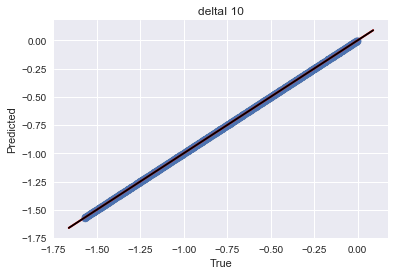

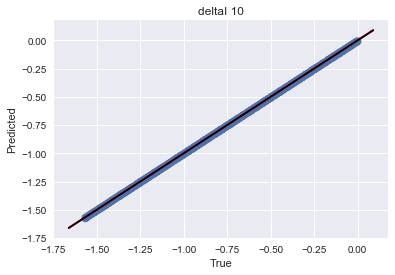

In [6]:
#Trying Independent Random Forest

rs = 42
md = 40
n = 40

E0MaDi_regr_RF2_dr_sp = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)


E0MaDi_model_RF2_dr_sp = E0MaDi_regr_RF2_dr_sp.fit(X1_train, Y1_train['deltaR'])

E0MaDi_predictions_RF2_dr_sp = E0MaDi_model_RF2_dr_sp.predict(X1_test)

E0MaDi_scores_RF2 = [r2_score(Y1_test['deltaR'], E0MaDi_predictions_RF2_dr_sp)]

#importance_RF_10 = pd.Series(model_RF2.feature_importances_, index = X_train.columns)

plotSummary(Y1_test['deltaR'], E0MaDi_predictions_RF2_dr_sp, 'deltaI 10')


In [ ]:
#Trying Independent Random Forest

rs = 42
md = 30
n = 30

E0MaDi_regr_RF2_dr_pi = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)

E0MaDi_model_RF2_dr_pi = E0MaDi_regr_RF2_dr_pi.fit(X2_train, Y2_train['deltaR'])

E0MaDi_predictions_RF2_dr_pi = E0MaDi_model_RF2_dr_pi.predict(X2_test)

E0MaDi_scores_RF2_pi = [r2_score(Y2_test['deltaR'], E0MaDi_predictions_RF2_dr_pi)]

plotSummary(Y2_test['deltaR'], E0MaDi_predictions_RF2_dr_pi, 'deltaI 10')


In [ ]:
#Trying Independent Random Forest

rs = 42
md = 30
n = 30

E0MaDi_regr_RF2_dr_both = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)

E0MaDi_model_RF2_dr_both = E0MaDi_regr_RF2_dr_both.fit(X_train, Y_train['deltaR'])

E0MaDi_predictions_RF2_dr_both = E0MaDi_model_RF2_dr_both.predict(X_test)

E0MaDi_scores_RF2_both = [r2_score(Y_test['deltaR'], E0MaDi_predictions_RF2_dr_both)]

plotSummary(Y_test['deltaR'], E0MaDi_predictions_RF2_dr_both, 'deltaI 10')



 
RMSE on test data: 0.00021288251227824355 for  AdaBoost Delta R
R^2 Score on test data: 0.9999997756470321 for AdaBoost Delta R
 
RMSE on test data: 0.00022064852093788486 for  AdaBoost Delta R
R^2 Score on test data: 0.9999997589795535 for AdaBoost Delta R


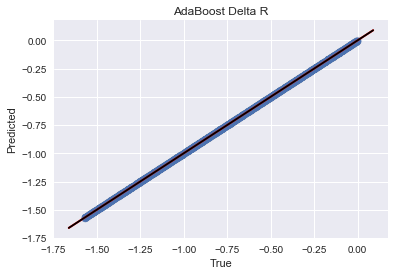

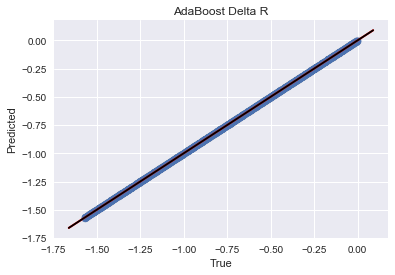

In [7]:
#Using AdaBoost Regression

from sklearn.ensemble import AdaBoostRegressor

rng = 42
md = 30
nest2 = 15

E0MaDi_regr_AB_dr_sp = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)

E0MaDi_model_AB_dr_sp = E0MaDi_regr_AB_dr_sp.fit(X1_train, Y1_train['deltaR'])

E0MaDi_predictions_AB_dr_sp = E0MaDi_model_AB_dr_sp.predict(X1_test)

E0MaDi_scores_AB = [r2_score(Y1_test['deltaR'], E0MaDi_predictions_AB_dr_sp)]

plotSummary(Y1_test['deltaR'], E0MaDi_predictions_AB_dr_sp, 'AdaBoost Delta R')


In [ ]:
#Using AdaBoost Regression

from sklearn.ensemble import AdaBoostRegressor

rng = 42
md = 30
nest2 = 15

E0MaDi_regr_AB_dr_pi = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)

E0MaDi_model_AB_dr_pi = E0MaDi_regr_AB_dr_pi.fit(X2_train, Y2_train['deltaR'])

E0MaDi_predictions_AB_dr_pi = E0MaDi_model_AB_dr_pi.predict(X2_test)

E0MaDi_scores_AB_pi = [r2_score(Y2_test['deltaR'], E0MaDi_predictions_AB_dr_pi)]

plotSummary(Y2_test['deltaR'], E0MaDi_predictions_AB_dr_pi, 'AdaBoost Delta R')


In [ ]:
#Using AdaBoost Regression

from sklearn.ensemble import AdaBoostRegressor

rng = 42
md = 30
nest2 = 15

E0MaDi_regr_AB_dr_both = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)

E0MaDi_model_AB_dr_both = E0MaDi_regr_AB_dr_both.fit(X_train, Y_train['deltaR'])

E0MaDi_predictions_AB_dr_both = E0MaDi_model_AB_dr_both.predict(X_test)

E0MaDi_scores_AB_both = [r2_score(Y_test['deltaR'], E0MaDi_predictions_AB_dr_both)]

plotSummary(Y_test['deltaR'], E0MaDi_predictions_AB_dr_both, 'AdaBoost Delta R')



 
RMSE on test data: 0.019053301037070147 for  GradientBoost Delta R
R^2 Score on test data: 0.9982028169913786 for GradientBoost Delta R
 
RMSE on test data: 0.01905646347482494 for  GradientBoost Delta R
R^2 Score on test data: 0.998202220354496 for GradientBoost Delta R


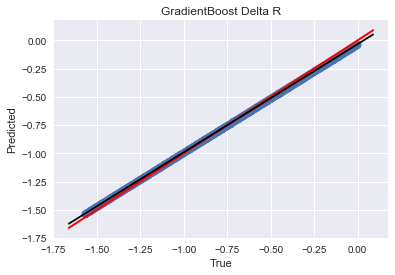

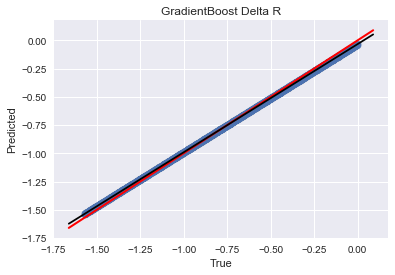

In [8]:
# Using Gradient Boosting Regression

from sklearn.ensemble import GradientBoostingRegressor

rng = 42

md = 50
nest2 = 30


E0MaDi_regr_GB_dr_sp = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)

E0MaDi_model_GB_dr_sp = E0MaDi_regr_GB_dr_sp.fit(X1_train, Y1_train['deltaR'])


E0MaDi_predictions_GB_dr_sp = E0MaDi_model_GB_dr_sp.predict(X1_test)

E0MaDi_scores_GB = [r2_score(Y1_test['deltaR'], E0MaDi_predictions_GB_dr_sp)]

plotSummary(Y1_test['deltaR'], E0MaDi_predictions_GB_dr_sp, 'GradientBoost Delta R')


In [ ]:
# Using Gradient Boosting Regression

from sklearn.ensemble import GradientBoostingRegressor

rng = 42

md = 50
nest2 = 30

E0MaDi_regr_GB_dr_pi = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)

E0MaDi_model_GB_dr_pi = E0MaDi_regr_GB_dr_pi.fit(X2_train, Y2_train['deltaR'])

E0MaDi_predictions_GB_dr_pi = E0MaDi_model_GB_dr_pi.predict(X2_test)

E0MaDi_scores_GB_pi = [r2_score(Y2_test['deltaR'], E0MaDi_predictions_GB_dr_pi)]

plotSummary(Y2_test['deltaR'], E0MaDi_predictions_GB_dr_pi, 'GradientBoost Delta R')




In [ ]:
# Using Gradient Boosting Regression

from sklearn.ensemble import GradientBoostingRegressor

rng = 42

md = 50
nest2 = 30

E0MaDi_regr_GB_dr_both = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)

E0MaDi_model_GB_dr_both = E0MaDi_regr_GB_dr_both.fit(X_train, Y_train['deltaR'])

E0MaDi_predictions_GB_dr_both = E0MaDi_model_GB_dr_both.predict(X_test)

E0MaDi_scores_GB_both = [r2_score(Y_test['deltaR'], E0MaDi_predictions_GB_dr_both)]

plotSummary(Y_test['deltaR'], E0MaDi_predictions_GB_dr_both, 'GradientBoost Delta R')



In [21]:
# Load the experimental data
col_names3 = peak_names + locs_names + width_names + prom_names
col_names4 = energy_names

exp_data_sp = pd.read_csv('Training_Data/Hexagon/HexagonExperimentalData062218_v8_specPoints.csv', header = None, names = col_names4)
exp_data_pi = pd.read_csv('Training_Data/Hexagon/HexagonExperimentalData062218_v8_peakinfo.csv', header = None, names = col_names3)

<<<<<<< local
col_names_exp_both = col_names_both[5:]
col_names_exp_pi = col_names2a[5:]
col_names_exp_a = col_names_a[5:]

exp_data_both = exp_data_sp.join(exp_data_pi, how = 'left')
exp_data_both = exp_data_both[col_names_exp_both]

exp_data_sp = exp_data_sp[col_names_exp_a]
exp_data_pi = exp_data_pi[col_names_exp_pi]

=======
>>>>>>> remote
E0MaDi_pred_phase_OLS_R_sp = E0MaDi_results_OLS_R_sp.predict(exp_data_sp)

E0MaDi_pred_phase_OLS_R_pi = E0MaDi_results_OLS_R_pi.predict(exp_data_pi)

E0MaDi_phases_OLS_sp = [E0MaDi_pred_phase_OLS_R_pi[0]]
E0MaDi_phases_OLS_pi = [E0MaDi_pred_phase_OLS_R_pi[0]]

#pred_phase_DT_sp = np.append(regr_DT_sp.predict(exp_data_sp),r2_score(Y1_test['deltaI'], predictions_DT_sp[:,0])).reshape(3,1).T
#pred_phase_DT_sp = np.append(pred_phase_DT_sp, r2_score(Y1_test['deltaR'], predictions_DT_sp[:,1])).reshape(4,1).T
#pred_phase_DT = np.append(pred_phase_DT, r2_score(Y_test['scale_factor'], y_pred_DT[:,2]))
E0MaDi_phases_DT_sp = E0MaDi_regr_DT_sp.predict(exp_data_sp)
E0MaDi_phases_DT_pi = E0MaDi_regr_DT_pi.predict(exp_data_pi)

E0MaDi_phases_RF_sp = E0MaDi_regr_RF_sp.predict(exp_data_sp)
E0MaDi_phases_RF_pi = E0MaDi_regr_RF_pi.predict(exp_data_pi)

E0MaDi_pred_phase_AB_R_sp = E0MaDi_model_AB_dr_sp.predict(exp_data_sp)

E0MaDi_pred_phase_AB_R_pi = E0MaDi_model_AB_dr_pi.predict(exp_data_pi)

E0MaDi_phases_AB_sp = [E0MaDi_pred_phase_AB_R_sp[0]]

E0MaDi_phases_AB_pi = [E0MaDi_pred_phase_AB_R_pi[0]]

E0MaDi_pred_phase_GB_dr_sp = E0MaDi_model_GB_dr_sp.predict(exp_data_sp)

E0MaDi_pred_phase_GB_dr_pi = E0MaDi_model_GB_dr_pi.predict(exp_data_pi)

E0MaDi_phases_GB_sp = [E0MaDi_pred_phase_GB_dr_sp[0]]

E0MaDi_phases_GB_pi = [E0MaDi_pred_phase_GB_dr_pi[0]]

E0MaDi_pred_phase_IRF_dr_sp = E0MaDi_model_RF2_dr_sp.predict(exp_data_sp)

E0MaDi_pred_phase_IRF_dr_pi = E0MaDi_model_RF2_dr_pi.predict(exp_data_pi)

E0MaDi_phases_IRF_sp = [E0MaDi_pred_phase_IRF_dr_sp[0]]

E0MaDi_phases_IRF_pi = [E0MaDi_pred_phase_IRF_dr_pi[0]]

E0MaDi_predictedPhases = pd.DataFrame([], columns = ['deltaR'])

E0MaDi_predictedPhases.loc['OLS_sp'] = E0MaDi_phases_OLS_sp
E0MaDi_predictedPhases.loc['OLS_pi'] = E0MaDi_phases_OLS_pi
E0MaDi_predictedPhases.loc['DT_sp'] = E0MaDi_phases_DT_sp.tolist()[0]
E0MaDi_predictedPhases.loc['DT_pi'] = E0MaDi_phases_DT_pi.tolist()[0]
E0MaDi_predictedPhases.loc['RF_sp'] = E0MaDi_phases_RF_sp.tolist()[0]
E0MaDi_predictedPhases.loc['RF_pi'] = E0MaDi_phases_RF_pi.tolist()[0]
E0MaDi_predictedPhases.loc['IRF_sp'] = E0MaDi_phases_IRF_sp
E0MaDi_predictedPhases.loc['IRF_pi'] = E0MaDi_phases_IRF_pi
E0MaDi_predictedPhases.loc['AB_sp'] = E0MaDi_phases_AB_sp
E0MaDi_predictedPhases.loc['AB_pi'] = E0MaDi_phases_AB_pi
E0MaDi_predictedPhases.loc['GB_sp'] = E0MaDi_phases_GB_sp
E0MaDi_predictedPhases.loc['GB_pi'] = E0MaDi_phases_GB_pi

E0MaDi_Scores = pd.DataFrame([], columns = ['deltaR'])

E0MaDi_Scores.loc['OLS_sp'] = E0MaDi_scores_OLS
E0MaDi_Scores.loc['OLS_pi'] = E0MaDi_scores_OLS_pi
E0MaDi_Scores.loc['DT_sp'] = E0MaDi_scores_DT
E0MaDi_Scores.loc['DT_pi'] = E0MaDi_scores_DT_pi
E0MaDi_Scores.loc['RF_sp'] = E0MaDi_scores_RF
E0MaDi_Scores.loc['RF_pi'] = E0MaDi_scores_RF_pi
E0MaDi_Scores.loc['IRF_sp'] = E0MaDi_scores_RF2
E0MaDi_Scores.loc['IRF_pi'] = E0MaDi_scores_RF2_pi
E0MaDi_Scores.loc['AB_sp'] = E0MaDi_scores_AB
E0MaDi_Scores.loc['AB_pi'] = E0MaDi_scores_AB_pi
E0MaDi_Scores.loc['GB_sp'] = E0MaDi_scores_GB
E0MaDi_Scores.loc['GB_pi'] = E0MaDi_scores_GB_pi

E0MaDi_Scores

,deltaR
OLS_sp,1.000000
OLS_pi,0.999145
OLS_both,1.000000
DT_sp,0.999999
DT_pi,0.999999
DT_both,0.999999
RF_sp,1.000000
RF_pi,1.000000
RF_both,1.000000
IRF_sp,1.000000


In [22]:
score_threshold = 0.98

avg_dr = E0MaDi_predictedPhases[E0MaDi_Scores > score_threshold]['deltaR'].mean()

avg_dr

0.22821804235220366

In [23]:
E0MaDi_predictedPhases.drop(['OLS_sp', 'OLS_pi'], axis = 0).mean()

deltaR   -0.168575
dtype: float64

In [32]:
E0MaDi_predictedPhases.drop(['OLS_sp', 'OLS_pi', 'OLS_both'], axis = 0).mean()

deltaR   -0.168738
dtype: float64

In [31]:
E0MaDi_predictedPhases.drop(['OLS_sp', 'OLS_pi', 'OLS_both'], axis = 0)

,deltaR
DT_sp,-0.178408
DT_pi,-0.202215
DT_both,-0.013288
RF_sp,-0.284026
RF_pi,-0.141946
RF_both,-0.146040
IRF_sp,-0.266230
IRF_pi,-0.141946
IRF_both,-0.146040
AB_sp,-0.145833


In [26]:
E0MaDi_predictedPhases

,deltaR
OLS_sp,3.402559
OLS_pi,3.402559
OLS_both,-0.166130
DT_sp,-0.178408
DT_pi,-0.202215
DT_both,-0.013288
RF_sp,-0.284026
RF_pi,-0.141946
RF_both,-0.146040
IRF_sp,-0.266230


In [27]:
if save_uniform == True:
<<<<<<< local
    E0MaDi_predictedPhases.to_csv('Model_Results/Hexagon/predictions_v7_threekinds_E0MaDifixed_uniformtraining_limitallrange300_removepeak1prom1.csv')
    E0MaDi_Scores.to_csv('Model_Results/Hexagon/scores_v7_threekinds_E0MaDifixed_uniformtraining_limitallrange300_removepeak1prom1.csv')
if save_random == True:
    E0MaDi_predictedPhases.to_csv('Model_Results/Hexagon/predictions_v7_threekinds_E0MaDifixed_randomtraining_limitallrange300_removepeak1prom1.csv')
    E0MaDi_Scores.to_csv('Model_Results/Hexagon/scores_v7_threekinds_E0MaDifixed_randomtraining_limitallrange300_removepeak1prom1.csv')
=======
    E0MaDi_predictedPhases.to_csv('Model_Results/Hexagon/predictions_v7_bothkinds_E0MaDifixed_uniformtraining.csv')
    E0MaDi_Scores.to_csv('Model_Results/Hexagon/scores_v7_bothkinds_E0MaDifixed_uniformtraining.csv')
if save_random == True:
    E0MaDi_predictedPhases.to_csv('Model_Results/Hexagon/predictions_v7_bothkinds_E0MaDifixed_randomtraining.csv')
    E0MaDi_Scores.to_csv('Model_Results/Hexagon/scores_v7_bothkinds_E0MaDifixed_randomtraining.csv')
>>>>>>> remote

## Investigating Error Measures


In [28]:

import forestci as fci

RF_error_sp = fci.random_forest_error(E0MaDi_model_RF2_dr_sp, X3_train,
                                            X3_test)

Failed to import duecredit due to No module named 'duecredit'


In [29]:
np.sqrt(RF_error_sp)

array([0.59718421, 0.60138133, 0.59672127, ..., 0.59836993, 0.60022973,
       0.60141634])

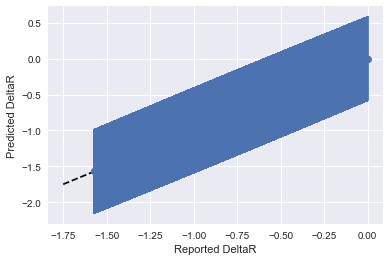

In [30]:
plt.errorbar(Y3_test['deltaR'], E0MaDi_predictions_RF2_dr_sp, yerr=np.sqrt(RF_error_sp), fmt='o')
plt.plot([-1.75,0], [-1.75,0], 'k--')
plt.xlabel('Reported DeltaR')
plt.ylabel('Predicted DeltaR')
plt.show()